- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [54]:
#Get data 
loader = DatasetLoader()
#loader.read_dataset('./partial_database.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./features_resnet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./features_googlenet.csv',class_path='labelsDefault.txt',separator=',')
loader.read_dataset('./features_mobilenet.csv',class_path='labelsDefault.txt',separator=',')

loader.X=loader.normalize_features([0,loader.df.shape[1]],"MinMaxScaler")

loader.add_dataset(file_path='./features_googlenet.csv')
#loader.add_dataset(file_path='./features_mobilenet.csv')
#loader.add_dataset(file_path='./partial_database.csv')
   

loader.split_dataset()
#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 832) (1012, 832) (4048,) (1012,)


In [55]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)
model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))


Partial fit
Score accuracy group 0:  0.453416149068323
Score accuracy group learned 0:  0.453416149068323
Score accuracy global:  0.15217391304347827
Memory:  810.0618489583334 MB
Partial fit
Score accuracy group 1:  0.3695652173913043
Score accuracy group learned 0:  0.422360248447205
Score accuracy group learned 1:  0.3695652173913043
Score accuracy global:  0.18379446640316205
Memory:  810.4401041666666 MB
Partial fit
Score accuracy group 2:  0.3967391304347826
Score accuracy group learned 0:  0.2950310559006211
Score accuracy group learned 1:  0.2391304347826087
Score accuracy group learned 2:  0.3967391304347826
Score accuracy global:  0.20454545454545456
Memory:  783.05859375 MB
Partial fit
Score accuracy group 3:  0.32608695652173914
Score accuracy group learned 0:  0.2732919254658385
Score accuracy group learned 1:  0.2391304347826087
Score accuracy group learned 2:  0.3532608695652174
Score accuracy group learned 3:  0.32608695652173914
Score accuracy global:  0.23418972332015

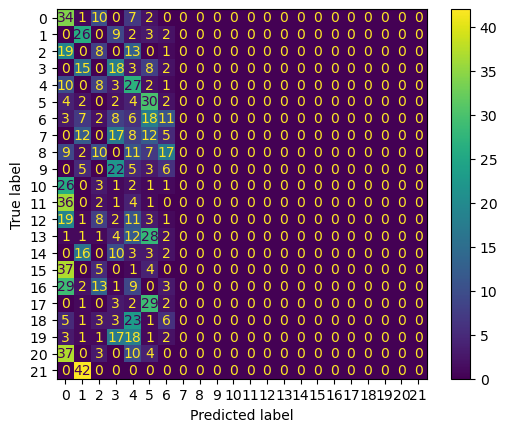

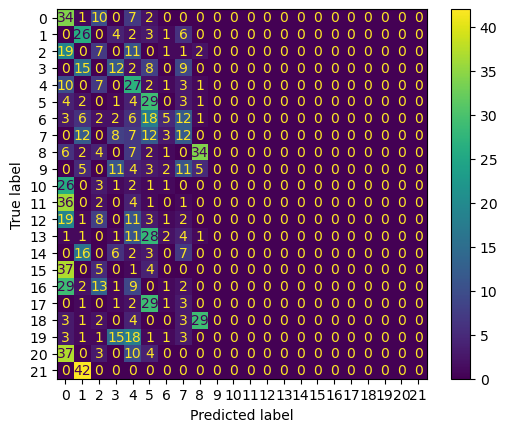

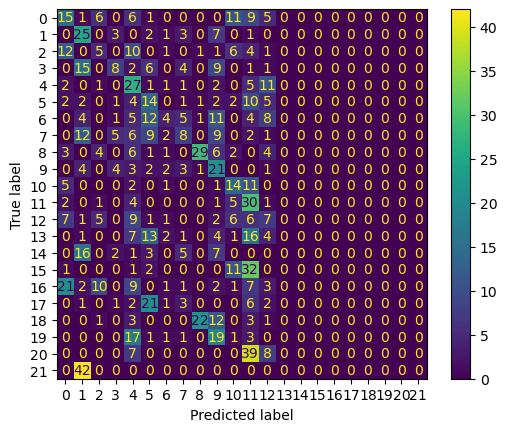

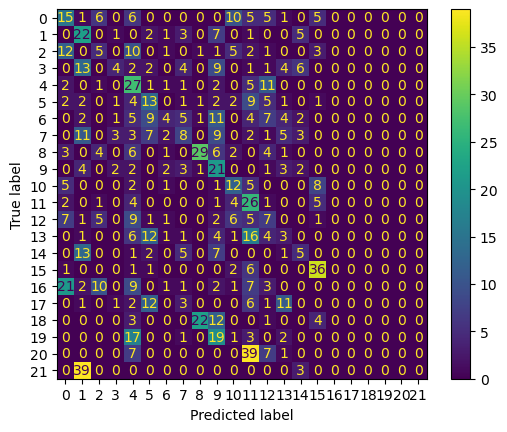

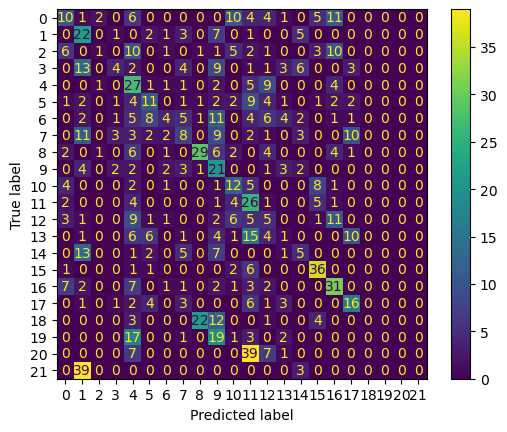

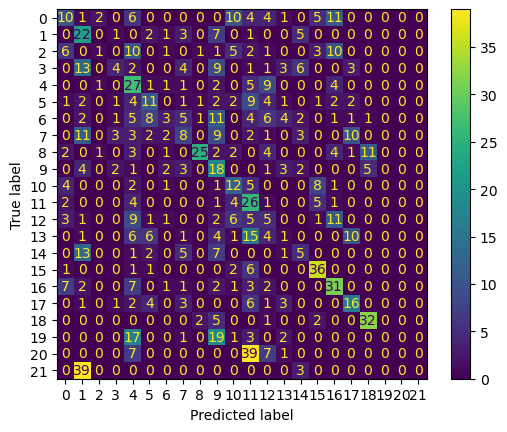

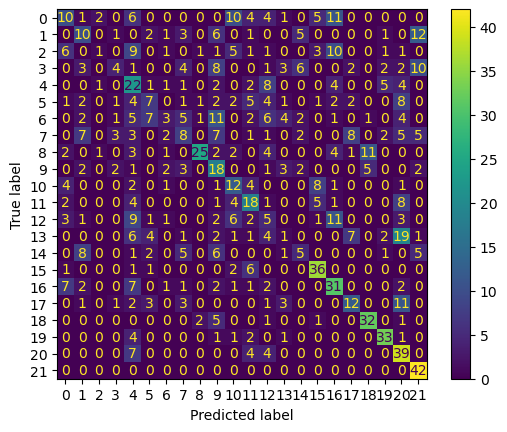

In [56]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
#class_to_group = {1:[1,2,3,4,5,6,7], 2:[8], 3:[9], 4:[10], 5:[11], 6:[12], 7:[13], 8:[14], 9:[15], 10:[16], 11:[17], 12:[18], 13:[19], 14:[20], 15:[21], 16:[22]}

X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []


#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

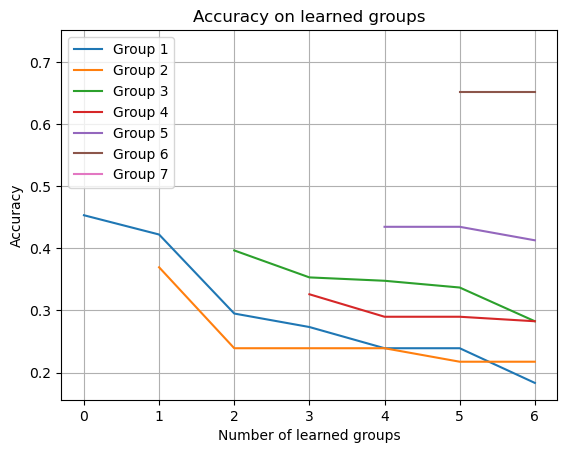

<Axes: title={'center': 'Accuracy on learned groups'}, xlabel='Number of learned groups', ylabel='Accuracy'>

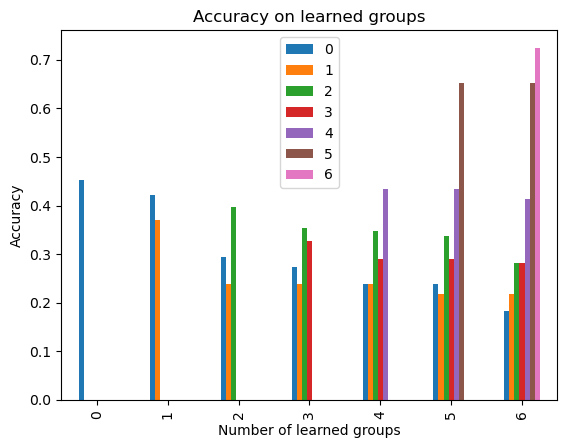

In [57]:
#Figure for accuracy on learned class
df = pd.DataFrame(accuracy_learned_grouped)
df1 = df.replace(np.nan, 0)
df=df.T

fig, ax = plt.subplots()
for i in range(len(class_to_group)):
    ax.plot(list(df.iloc[i]),label=f'Group {i+1}')

ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

ax.grid()
ax.legend()
plt.show()

# Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df1.plot(kind='bar', ax=ax)

In [58]:
test=model.model.feature_log_prob_
test

array([[ -5.84538434,  -5.14920126,  -7.70183349, ...,  -6.68528179,
         -6.73421405,  -7.06404301],
       [ -7.91032093,  -8.30034183,  -6.88645272, ...,  -7.65133416,
         -7.59236249,  -7.92953837],
       [ -5.96826703,  -5.08606855,  -7.52081606, ...,  -6.74692822,
         -6.73499852,  -7.10668339],
       ...,
       [ -8.7204922 ,  -8.91899663,  -8.13900523, ...,  -7.31944141,
         -7.12880465,  -7.54302143],
       [ -9.16153848,  -8.56477036,  -7.82732821, ...,  -6.95758464,
         -6.84046085,  -7.21179212],
       [-10.84424146, -10.45330521,  -9.65197292, ...,  -7.91955735,
         -7.99499793,  -8.30271919]])

Partial fit
Score accuracy batch 0:  0.39920948616600793
Score accuracy global:  0.3715415019762846
Memory:  791.0055803571429 MB
Partial fit
Score accuracy batch 1:  0.3715415019762846
Score accuracy global:  0.3695652173913043
Memory:  792.4185267857143 MB
Partial fit
Score accuracy batch 2:  0.3616600790513834
Score accuracy global:  0.37450592885375494
Memory:  782.3197544642857 MB
Partial fit
Score accuracy batch 3:  0.36561264822134387
Score accuracy global:  0.3725296442687747
Memory:  784.712890625 MB
Partial fit
Score accuracy batch 4:  0.35375494071146246
Score accuracy global:  0.3715415019762846
Memory:  784.728515625 MB
Partial fit
Score accuracy batch 5:  0.35375494071146246
Score accuracy global:  0.3725296442687747
Memory:  784.748046875 MB
Partial fit
Score accuracy batch 6:  0.3458498023715415
Score accuracy global:  0.3725296442687747
Memory:  783.6696428571429 MB
Partial fit
Score accuracy batch 7:  0.3675889328063241
Score accuracy global:  0.3725296442687747
Memor

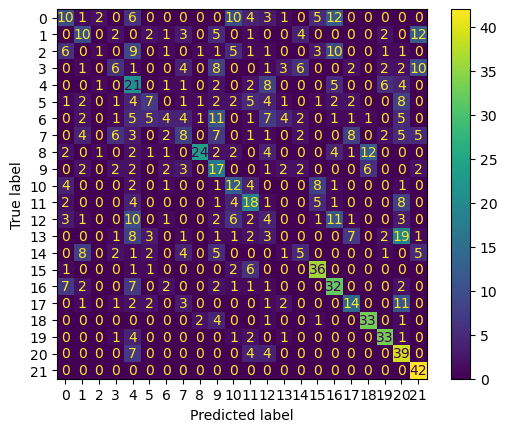

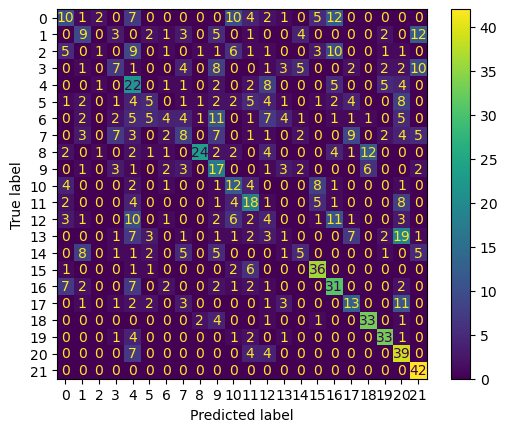

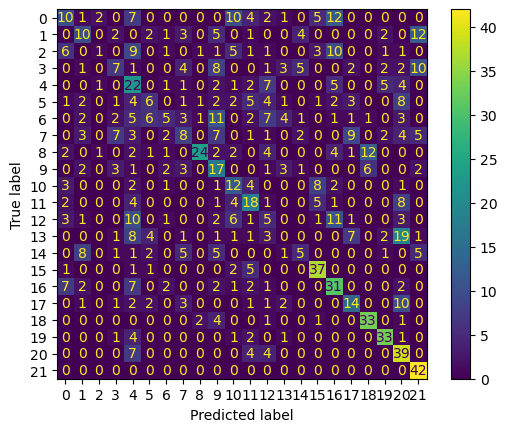

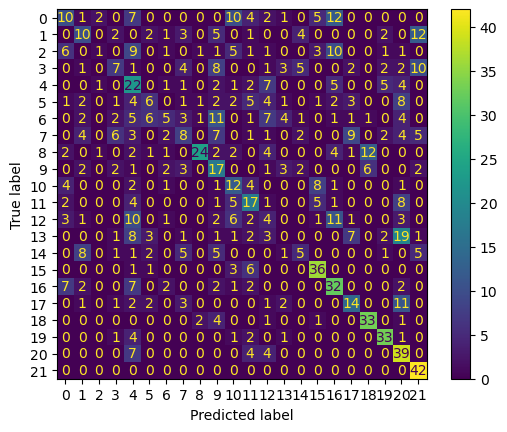

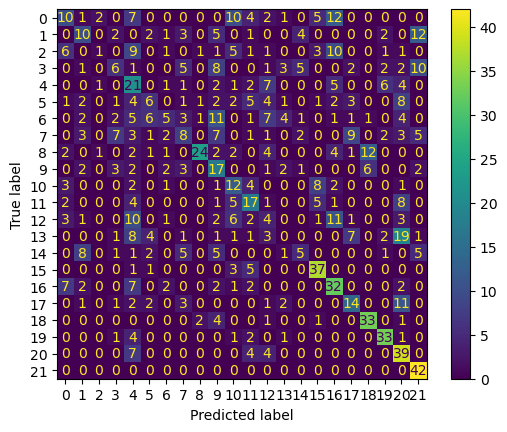

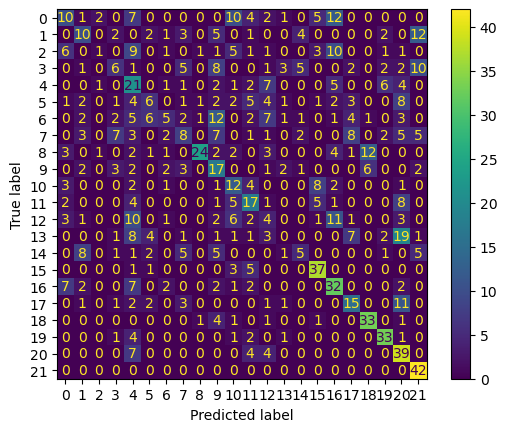

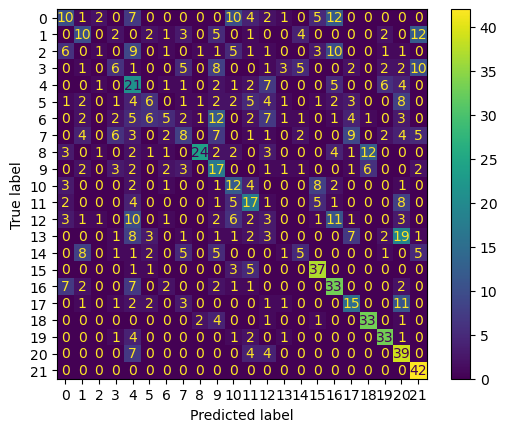

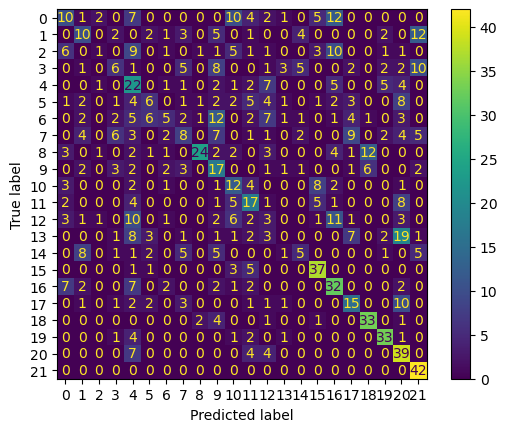

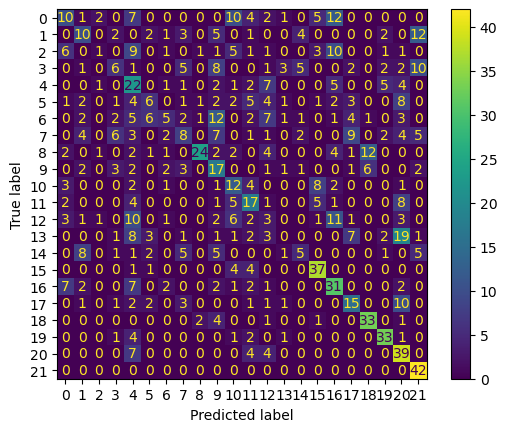

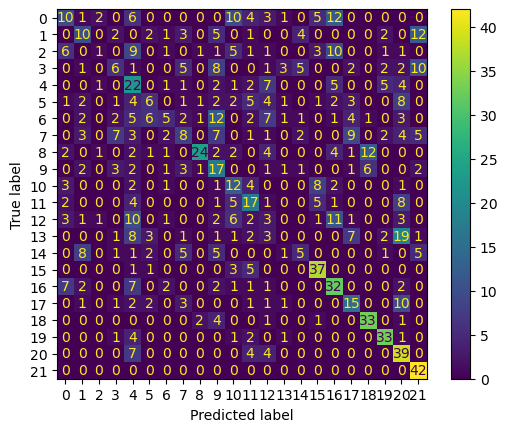

In [59]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")